In [ ]:
from pathlib import Path

import pandas as pd

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
data_base_dir = Path('/Users/janneke/Documents/Documents – Janneke’s MacBook/data/ocrpostcorrection')

In [ ]:
# OCR strings from the test dataset without duplicates
in_file = data_base_dir/'results'/'simple_correction_model_2023-01-14'/'predictions.csv'
data = pd.read_csv(in_file, index_col=0)

In [ ]:
# OCR strings from the test dataset with duplicates
in_file = data_base_dir/'results'/'simple_correction_model_2023-01-14'/'predictions_test_data.csv'
data = pd.read_csv(in_file, index_col=0)

In [ ]:
print(pd.DataFrame([data.ed.describe(), data.ed_pred.describe()])[['mean', 'std', 'min', '25%', '50%', '75%', 'max']].round(2).to_markdown())

|         |   mean |   std |   min |   25% |   50% |   75% |   max |
|:--------|-------:|------:|------:|------:|------:|------:|------:|
| ed      |   2.48 |  2.04 |     1 |     1 |     2 |     3 |    22 |
| ed_pred |   1.58 |  2.28 |     0 |     0 |     1 |     2 |    23 |


In [ ]:
def classify_ed_difference(row):
    result = None
    if row.ed_pred == 0:
        result = 'correct prediction'
    elif row.ed_pred < row.ed:
        result = 'edit distance improved'
    elif row.ed_pred == row.ed:
        if row.ocr == row.pred:
            result = 'no change (prediction equal to ocr)'
        else:
            result = 'no change (prediction not equal to ocr)'
    else:
        assert row.ed_pred > row.ed
        result = 'edit distance increased'
    return result

data['ed_diff_class'] = data.apply(lambda row: classify_ed_difference(row), axis=1)

In [ ]:
data['ed_diff_class'].value_counts()

correct prediction                         161637
edit distance improved                      75816
no change (prediction not equal to ocr)     49684
no change (prediction equal to ocr)         47639
edit distance increased                     45614
Name: ed_diff_class, dtype: int64

In [ ]:
print(pd.DataFrame([data['ed_diff_class'].value_counts(), (data['ed_diff_class'].value_counts()/data.shape[0] * 100)]).round(2).T.to_markdown())

|                                         |   ed_diff_class |   ed_diff_class |
|:----------------------------------------|----------------:|----------------:|
| correct prediction                      |          161637 |           42.49 |
| edit distance improved                  |           75816 |           19.93 |
| no change (prediction not equal to ocr) |           49684 |           13.06 |
| no change (prediction equal to ocr)     |           47639 |           12.52 |
| edit distance increased                 |           45614 |           11.99 |


<AxesSubplot: >

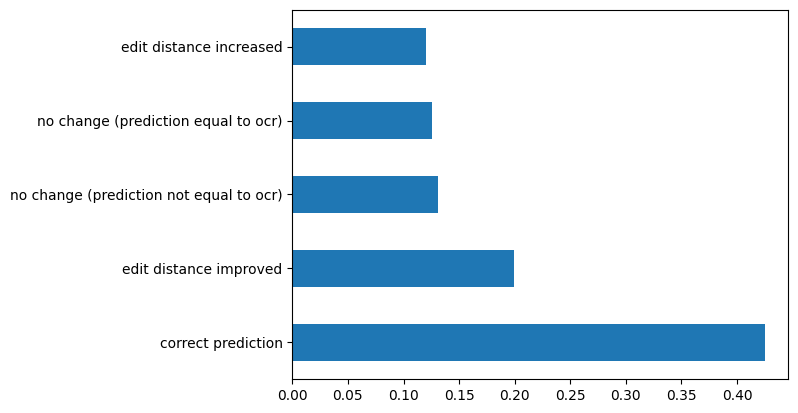

In [ ]:
(data['ed_diff_class'].value_counts()/data.shape[0]).plot(kind='barh')

In [ ]:
data.query('ed_diff_class == "no change (prediction equal to ocr)"').sample(5)[['ocr', 'gs', 'pred', 'ed', 'ed_pred']]

ocr           gs         pred  ed  ed_pred
25139   diligentis   diligencia   diligentis   2        2
21834        xviii       xviii.        xviii   1        1
6859             (            €            (   1        1
24970   esploitier  esploitier,   esploitier   1        1
7001   d'Angoulins  d’Angoulins  d'Angoulins   1        1

In [ ]:
data.query('ed_diff_class == "correct prediction"').sample(5)[['ocr', 'gs', 'pred', 'ed', 'ed_pred']]

ocr         gs       pred  ed  ed_pred
133522  redarguo .  redarguo.  redarguo.   1        0
375192       alfem      allem      allem   1        0
258700     madhte.    machte.    machte.   1        0
199439        Ddaß        daß        daß   1        0
270351    Gedanfen   Gedanken   Gedanken   1        0

In [ ]:
data.query('ed_diff_class == "edit distance increased"').sample(5)[['ocr', 'gs', 'pred', 'ed', 'ed_pred']]

ocr            gs          pred  ed  ed_pred
19022          igitur       igitur,        iittur   1        3
22048       Saint-Lou    Sainct Lou    Saint-louu   2        4
34587   Lohduttnkaitt  Lohduttakaat  Lodhutuikatt   3        5
65586           Wefel         Wesel         Gefel   1        2
132072        Cambyfe       Cambyſe        Sampte   1        4

Hypothesis: zero and smaller have mean shorter word length compared to same and larger
(model is better at correcting shorter words)

In [ ]:
data.groupby('ed_diff_class')['len_ocr'].describe()

count      mean       std  min  \
ed_diff_class                                                                
correct prediction                       161637.0  5.924176  3.024428  1.0   
edit distance improved                    75816.0  9.470402  4.135692  1.0   
edit distance increased                   45614.0  9.269106  4.956960  1.0   
no change (prediction equal to ocr)       47639.0  5.017003  2.720368  1.0   
no change (prediction not equal to ocr)   49684.0  6.646908  4.124140  1.0   

                                         25%  50%   75%   max  
ed_diff_class                                                  
correct prediction                       4.0  5.0   8.0  22.0  
edit distance improved                   6.0  9.0  12.0  22.0  
edit distance increased                  5.0  8.0  12.0  22.0  
no change (prediction equal to ocr)      3.0  5.0   7.0  17.0  
no change (prediction not equal to ocr)  4.0  6.0   9.0  22.0

<AxesSubplot: >

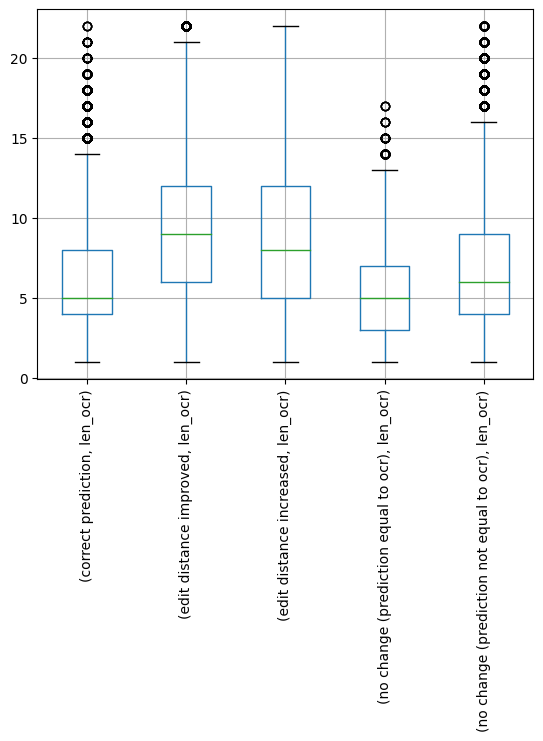

In [ ]:
data.groupby('ed_diff_class').boxplot(column='len_ocr', subplots=False, rot=90)

## Convert predictions to ICDAR output format

In [ ]:
test_data_dir = Path('/Users/janneke/Documents/Documents – Janneke’s MacBook/data/ICDAR2019_POCR_competition_dataset/ICDAR2019_POCR_competition_evaluation_4M_without_Finnish')

In [ ]:
from ocrpostcorrection.icdar_data import generate_data

data_test, md_test = generate_data(test_data_dir)

11it [00:06,  1.72it/s]


In [ ]:
from ocrpostcorrection.utils import create_perfect_icdar_output

output = create_perfect_icdar_output(data_test)

In [ ]:
output

{'SL/SL1/29.txt': {'0:141': {}, '528:2': {}},
 'SL/SL1/15.txt': {'0:1': {},
  '18:2': {},
  '23:1': {},
  '33:1': {},
  '46:1': {},
  '68:1': {},
  '80:1': {},
  '93:1': {},
  '105:1': {},
  '128:2': {},
  '138:1': {},
  '146:1': {},
  '172:1': {},
  '212:2': {},
  '232:1': {},
  '245:1': {},
  '263:1': {},
  '314:1': {},
  '340:1': {},
  '364:2': {},
  '371:2': {},
  '379:1': {},
  '384:1': {},
  '415:1': {},
  '429:1': {},
  '437:1': {},
  '445:2': {},
  '452:1': {}},
 'SL/SL1/14.txt': {'0:1': {},
  '4:1': {},
  '21:2': {},
  '44:1': {},
  '58:1': {},
  '76:2': {},
  '82:1': {},
  '85:1': {},
  '92:3': {},
  '106:1': {},
  '147:1': {},
  '163:1': {},
  '180:1': {},
  '183:1': {},
  '194:1': {},
  '203:1': {},
  '223:1': {},
  '236:1': {},
  '241:1': {},
  '258:1': {},
  '269:1': {},
  '299:1': {},
  '335:2': {},
  '349:1': {},
  '395:1': {},
  '406:1': {},
  '410:1': {},
  '445:1': {},
  '464:1': {},
  '483:1': {},
  '494:1': {},
  '498:1': {},
  '519:1': {},
  '536:1': {},
  '552:1'

In [ ]:
for i, row in data.iterrows():
    output[row.text][row.token][row.pred] = 1.0

In [ ]:
import json

out_json = data_base_dir/'results'/'simple_correction_model_2023-01-14'/'results_task1_perfect+task2_model.json'

with open(out_json, 'w') as f:
    json.dump(output, f)

In [ ]:
out_csv = out_json.with_suffix('.csv')

In [ ]:
from ocrpostcorrection.utils import runEvaluation

runEvaluation(test_data_dir, out_json, out_csv)

File	NbTokens	NbErroneousTokens	NbSymbolsConsidered	T1_Precision	T1_Recall	T1_Fmesure	T2_AvgLVDistOriginal	T2_AvgLVDistCorrected
SL/SL1/29.txt	2	2	532	1.00	1.00	1.00	0.99	0.99
SL/SL1/15.txt	83	28	404	1.00	1.00	1.00	0.15	0.20
SL/SL1/14.txt	115	50	624	1.00	1.00	1.00	0.16	0.19
SL/SL1/28.txt	273	21	1270	1.00	1.00	1.00	0.03	0.03
SL/SL1/16.txt	1004	182	4838	1.00	1.00	1.00	0.08	0.11
SL/SL1/17.txt	1009	333	4929	1.00	1.00	1.00	0.19	0.24
SL/SL1/13.txt	139	49	715	1.00	1.00	1.00	0.09	0.15
SL/SL1/12.txt	333	30	1491	1.00	1.00	1.00	0.03	0.04
SL/SL1/10.txt	314	36	1278	1.00	1.00	1.00	0.05	0.10
SL/SL1/38.txt	405	33	1995	1.00	1.00	1.00	0.03	0.03
SL/SL1/39.txt	143	73	694	1.00	1.00	1.00	0.15	0.20
SL/SL1/11.txt	238	19	1127	1.00	1.00	1.00	0.03	0.04
SL/SL1/9.txt	214	100	1047	1.00	1.00	1.00	0.17	0.25
SL/SL1/8.txt	1140	99	5725	1.00	1.00	1.00	0.04	0.05
SL/SL1/5.txt	263	15	1041	1.00	1.00	1.00	0.02	0.02
SL/SL1/43.txt	172	56	883	1.00	1.00	1.00	0.09	0.12
SL/SL1/42.txt	70	31	296	1.00	1.00	1.00	0.20	0.23
SL/SL1/4.txt	

In [ ]:
from ocrpostcorrection.utils import read_results

data = read_results(out_csv)

In [ ]:
data[data.T2_AvgLVDistOriginal > data.T2_AvgLVDistCorrected].shape[0]/data.shape[0] * 100

71.74342105263159

In [ ]:
print(data.groupby('language').mean(numeric_only=True)[['T1_Precision', 'T1_Recall', 'T1_Fmesure', 'T2_AvgLVDistOriginal', 'T2_AvgLVDistCorrected']].to_markdown(floatfmt='.6f'))

| language   |   T1_Precision |   T1_Recall |   T1_Fmesure |   T2_AvgLVDistOriginal |   T2_AvgLVDistCorrected |
|:-----------|---------------:|------------:|-------------:|-----------------------:|------------------------:|
| BG         |       1.000000 |    1.000000 |     1.000000 |               0.209796 |                0.248980 |
| CZ         |       1.000000 |    1.000000 |     1.000000 |               0.068696 |                0.084130 |
| DE         |       1.000000 |    0.998003 |     0.999418 |               0.283328 |                0.151953 |
| EN         |       1.000000 |    1.000000 |     1.000000 |               0.221667 |                0.231042 |
| ES         |       1.000000 |    1.000000 |     1.000000 |               0.369800 |                0.369000 |
| FI         |       1.000000 |    0.932000 |     0.962125 |               0.067500 |                0.062625 |
| FR         |       1.000000 |    0.997399 |     0.998598 |               0.104527 |                0.1